<a href="https://colab.research.google.com/github/scott-huberty/DeepUnderstandingOfDeepLearning/blob/codechallenges/FFN/DUDL_FFN_CodeChallenge_missing7_Scott.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: CodeChallenge: The mystery of the missing 7
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

In [23]:
# convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()



# boolean vector with the 7's
where7 = np.where(labels==7)[0]
not7  = np.where(labels!=7)[0]
assert 7 in labels[where7]
assert 7 not in labels[not7]

# separate data into tensors with, and without, 7's
data_missing_7 = dataT[not7, :]
labels_missing_7 = labelsT[not7]
data_with_7 = dataT[where7, :]
labels_with_7 = labelsT[where7]
# don't need the labels! ;)



# convert into PyTorch Datasets
train_data = TensorDataset(data_missing_7, labels_missing_7)
test_data  = TensorDataset(data_with_7)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True
    )

test_loader  = DataLoader(
    test_data, batch_size=test_data.tensors[0].shape[0]
    )

In [24]:
# confirm that the separation is accurate
np.unique(labels_missing_7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

# Create the DL model

In [25]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784, 64)

      ### hidden layer
      self.fc1 = nn.Linear(64, 32)
      self.fc2 = nn.Linear(32, 32)

      ### output layer
      self.output = nn.Linear(32, 10) # NOTE: still 10 outputs, but output #7 is never trained

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: log-softmax output for later inspection

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(), lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [26]:
# a function that trains the model

# NOTE: anything test-related can be deleted!

def function2trainTheModel():

  # number of epochs
  numepochs = 100

  # create a new model
  net, lossfun, optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X, y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat, axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
  # end epochs

  # function output
  return trainAcc, losses, net


# Run the model and show the results!

In [27]:
trainAcc, losses, net = function2trainTheModel()


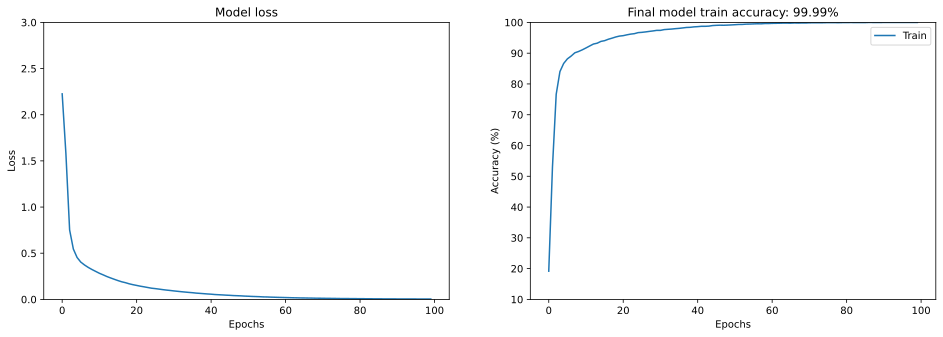

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Now for the mystery test!

In [29]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()
# save the model guesses
guesses = torch.argmax(predictions, axis=1).detach()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [65]:
with np.printoptions(precision=3, suppress=True):
  print(torch.exp(predictions[0]).numpy())

[0.024 0.    0.    0.    0.    0.    0.    0.    0.    0.976]


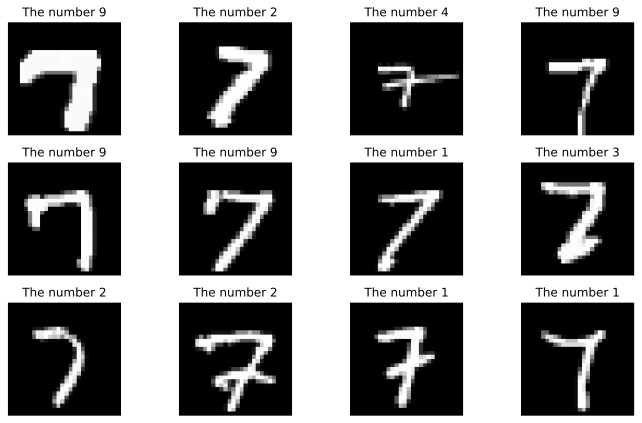

In [51]:
# show some 7's and their labels

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

some_random_7s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):

  this_img = X[some_random_7s[i]].view(28, 28) # reshape into image
  ax.imshow(this_img, cmap='gray')
  ax.set_title(f'The number {guesses[ some_random_7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


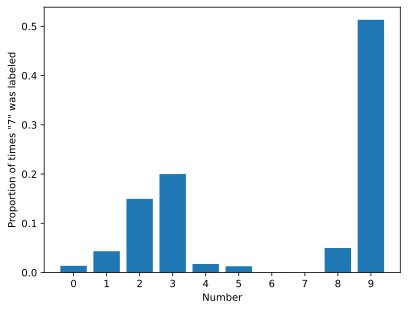

In [53]:
# which numbers are most likely to be confused with 7?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

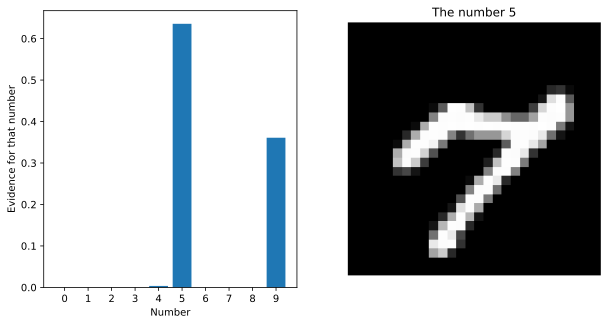

In [60]:
# Evidence for all numbers from one sample
sample2show = np.random.choice(len(X))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

this_img = X[sample2show].view(28, 28) # reshape into image
ax[1].imshow(this_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'The number {guesses[ sample2show ]}')

ax[0].bar(range(10), torch.exp(predictions[sample2show]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
fig.show()

### Additional Explorations

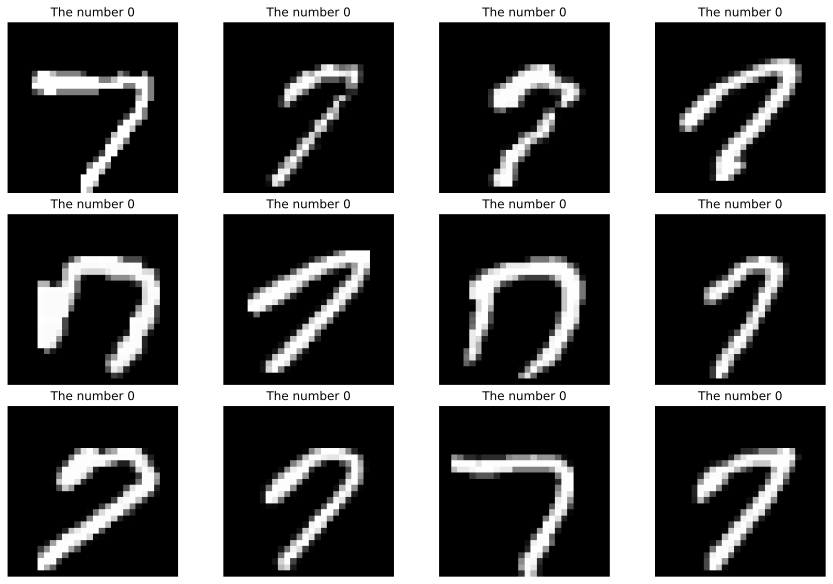

In [89]:
# 1) In the image matrix we created above, we picked random 7's and showed their labels. Create another image
#    matrix to show all of the times that a 7 was labeled "0". How do those 7's look? You can re-run this for
#    the other numbers.

fig, axs = plt.subplots(3, 4, figsize=(12, 8), constrained_layout=True)

img_where_model_labeled_0 = X[guesses == 0]
label_where_model_labeled_0 = guesses[guesses == 0]
some_random_zero_guesses = np.random.choice(len(img_where_model_labeled_0), 12)

for i, ax in enumerate(axs.flatten()):

  this_img = img_where_model_labeled_0[i].view(28, 28) # reshape into image
  ax.imshow(this_img, cmap='gray')
  ax.set_title(f'The number {label_where_model_labeled_0[i]}')
  ax.axis('off')

fig.show()

In [91]:

# 2) It's not surprising that most of the 7's were labeled as "9". You can now repeat this code file with other numbers
#    left out. What other pair of numbers do you expect to be commonly misclassified based on typographical similarity?
#

# boolean vector with the 7's
where_0 = np.where(labels==0)[0]
not_0  = np.where(labels!=0)[0]
assert 0 in labels[where_0]
assert 0 not in labels[not_0]

# separate data into tensors with, and without, 7's
data_missing_0 = dataT[not_0, :]
labels_missing_0 = labelsT[not_0]
data_with_0 = dataT[where_0, :]
labels_with_0 = labelsT[where_0]
# don't need the labels! ;)



# convert into PyTorch Datasets
train_data = TensorDataset(data_missing_0, labels_missing_0)
test_data  = TensorDataset(data_with_0)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True
    )

test_loader  = DataLoader(
    test_data, batch_size=test_data.tensors[0].shape[0]
    )

# confirm that the separation is accurate
print(np.unique(labels_missing_0))

trainAcc, losses, net = function2trainTheModel()


[1 2 3 4 5 6 7 8 9]


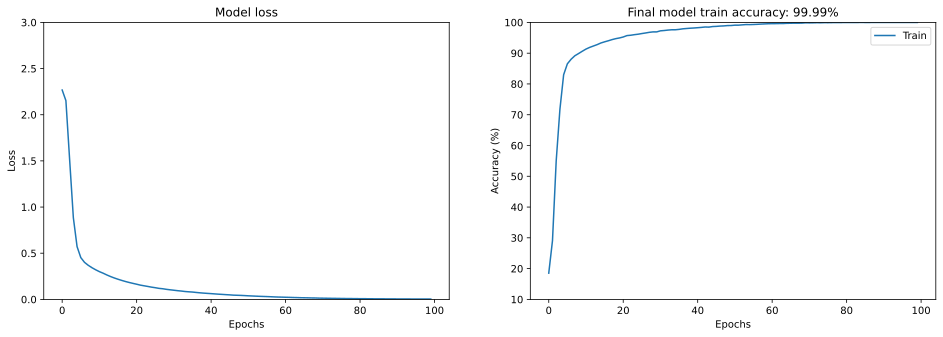

In [92]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [93]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()
# save the model guesses
guesses = torch.argmax(predictions, axis=1).detach()

In [94]:
with np.printoptions(precision=3, suppress=True):
  print(torch.exp(predictions[0]).numpy())

[0.    0.    0.    0.005 0.    0.995 0.    0.    0.    0.   ]


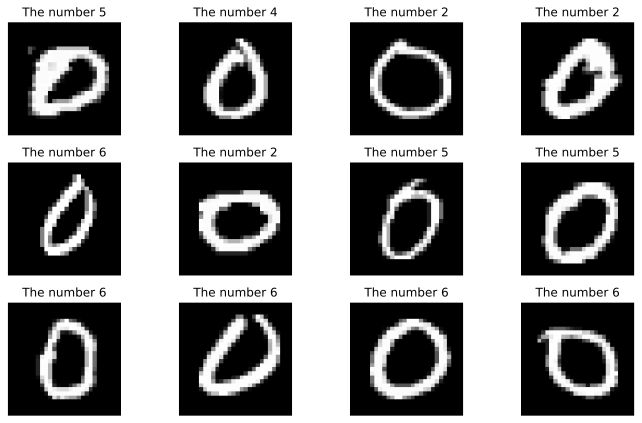

In [95]:
# show some 0's and their labels

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

some_random_0s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):

  this_img = X[some_random_0s[i]].view(28, 28) # reshape into image
  ax.imshow(this_img, cmap='gray')
  ax.set_title(f'The number {guesses[ some_random_0s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

[2 3 4 5 6 7 8 9]


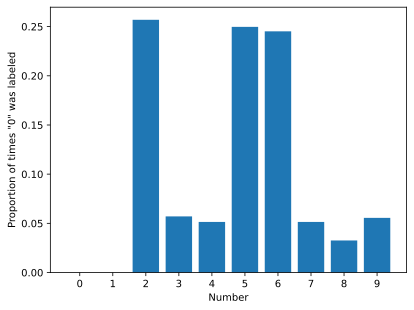

In [97]:
# which numbers are most likely to be confused with 0?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "0" was labeled')
plt.show()

In [98]:
# 3) Add dropout regularization to fc1 and fc2 (what else do you need to modify in the code to make sure the dropout
#    is applied only during training?). Does that affect how the model categorizes 7's?
#

# redefine model but add dropout reg to fc1 and fc2

# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784, 64)

      ### hidden layer
      self.fc1 = nn.Linear(64, 32)
      self.fc2 = nn.Linear(32, 32)
      # add dropout layers
      self.dropout = nn.Dropout(p=0.5)

      ### output layer
      self.output = nn.Linear(32, 10) # NOTE: still 10 outputs, but output #7 is never trained

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = self.dropout(x) # apply dropout to output of fc1
      x = F.relu( self.fc2(x) )
      x = self.dropout(x) # apply dropout to output of fc2
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: log-softmax output for later inspection

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(), lr=.01)

  return net,lossfun,optimizer

In [99]:

# boolean vector with the 7's
where7 = np.where(labels==7)[0]
not7  = np.where(labels!=7)[0]
assert 7 in labels[where7]
assert 7 not in labels[not7]

# separate data into tensors with, and without, 7's
data_missing_7 = dataT[not7, :]
labels_missing_7 = labelsT[not7]
data_with_7 = dataT[where7, :]
labels_with_7 = labelsT[where7]
# don't need the labels! ;)



# convert into PyTorch Datasets
train_data = TensorDataset(data_missing_7, labels_missing_7)
test_data  = TensorDataset(data_with_7)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True
    )

test_loader  = DataLoader(
    test_data, batch_size=test_data.tensors[0].shape[0]
    )

In [100]:
np.unique(labels_missing_7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [101]:
trainAcc, losses, net = function2trainTheModel()


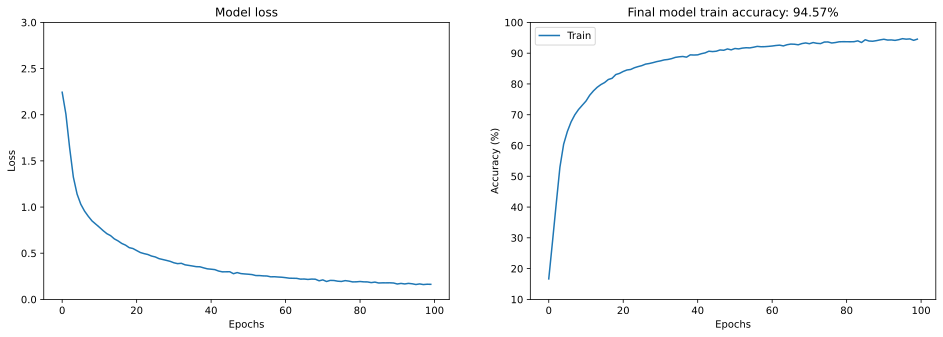

In [102]:
fig,ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [103]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()
# save the model guesses
guesses = torch.argmax(predictions, axis=1).detach()

In [104]:
with np.printoptions(precision=3, suppress=True):
  print(torch.exp(predictions[0]).numpy())

[0.03  0.    0.    0.185 0.    0.785 0.    0.    0.    0.   ]


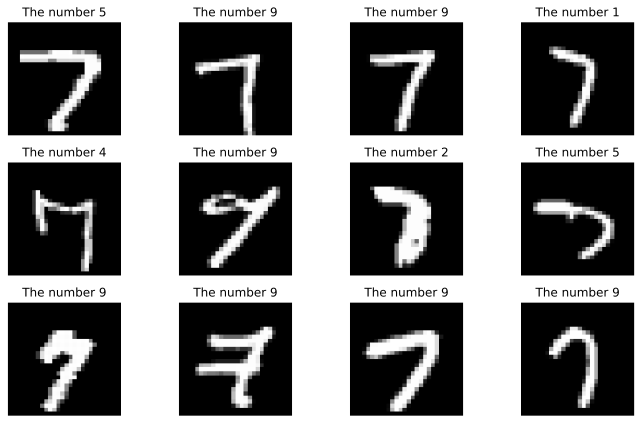

In [105]:
# show some 0's and their labels

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

some_random_7s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):

  this_img = X[some_random_7s[i]].view(28, 28) # reshape into image
  ax.imshow(this_img, cmap='gray')
  ax.set_title(f'The number {guesses[ some_random_7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


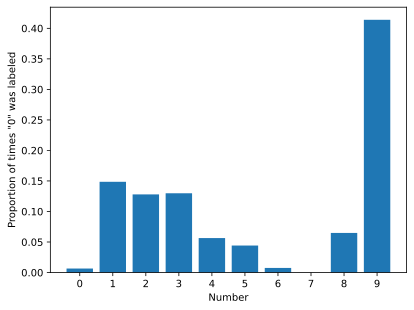

In [106]:
# which numbers are most likely to be confused with 0?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "0" was labeled')
plt.show()

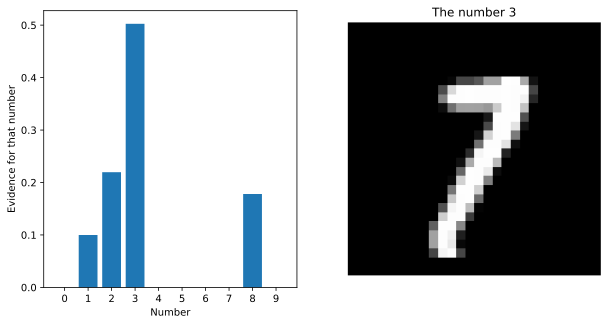

In [109]:
# Evidence for all numbers from one sample
sample2show = np.random.choice(len(X))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

this_img = X[sample2show].view(28, 28) # reshape into image
ax[1].imshow(this_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'The number {guesses[ sample2show ]}')

ax[0].bar(range(10), torch.exp(predictions[sample2show]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
fig.show()